<a href="https://colab.research.google.com/github/notenoughsun/bayes_ML/blob/master/2020_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome

In this task, you are asked to be a bit bayesian (also, you can see: https://arxiv.org/abs/2002.10118). We consider the nice dataset: pictures with animal faces. It could be found and downloaded here: https://www.kaggle.com/andrewmvd/animal-faces and contain 3 classes of images: cat, dog and wild. The deep neural networks are known to be overconfient, so we make some attempts to mitigate this problem.

1. We start from the ordinary training of the NN.
2. Then we consider the Laplace approximation of the trained NN. The advantage of the such approach is that we did not change the training procedure.
3. Finaly, we consider the training with ELBO optimization in order to find the gaussian posterior.

As the feature extractor $\phi(x)$ for this problem we will use ResNet18 ```torchvision.models.resnet18(pretrained=True)``` and train only the last FC layer.

#### Links of problems:
[Problem 1](#problem1) 10 points

[Problem 2](#problem2) 20points

[Problem 3](#problem3) 20 points 

------ Total : 50 points  -------

In [1]:
import numpy as np
import matplotlib.pylab as plt

import torch
import torch.nn as nn

import torchvision

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy

import glob
from PIL import Image

from scipy.special import softmax

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.image as mpimg
mpl.rcParams['figure.dpi'] = 200

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Model

Consider dataset

$$
\begin{aligned}
& \{(x_n, y_n)\}_{n=1}^{N} \\
& x_n\in\mathbb{R}^{3\times D\times D} \text{ animal face images} \\
& y_n\in\{1,2,3\} \text{ labels}
\end{aligned}
$$

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
%mkdir /content/data/
%cp /content/gdrive/My\ Drive/archive.zip /content/data/
!f="archive.zip" && unzip -q /content/data/$f  && rm $f

Mounted at /content/gdrive
rm: cannot remove 'archive.zip': No such file or directory


In [7]:
%ls /content/data/
!unzip /content/data/archive.zip
%ls /content/data/
%ls ./afhq/

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: afhq/train/wild/flickr_wild_001381.jpg  
  inflating: afhq/train/wild/flickr_wild_001382.jpg  
  inflating: afhq/train/wild/flickr_wild_001384.jpg  
  inflating: afhq/train/wild/flickr_wild_001385.jpg  
  inflating: afhq/train/wild/flickr_wild_001386.jpg  
  inflating: afhq/train/wild/flickr_wild_001387.jpg  
  inflating: afhq/train/wild/flickr_wild_001388.jpg  
  inflating: afhq/train/wild/flickr_wild_001389.jpg  
  inflating: afhq/train/wild/flickr_wild_001390.jpg  
  inflating: afhq/train/wild/flickr_wild_001391.jpg  
  inflating: afhq/train/wild/flickr_wild_001392.jpg  
  inflating: afhq/train/wild/flickr_wild_001393.jpg  
  inflating: afhq/train/wild/flickr_wild_001394.jpg  
  inflating: afhq/train/wild/flickr_wild_001395.jpg  
  inflating: afhq/train/wild/flickr_wild_001396.jpg  
  inflating: afhq/train/wild/flickr_wild_001399.jpg  
  inflating: afhq/train/wild/flickr_wild_001400.jpg  
  inflating: a

In [8]:
#@title
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy

import glob
from PIL import Image

from scipy.special import softmax

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.image as mpimg
mpl.rcParams['figure.dpi'] = 200

img_size = (300, 300)

# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor()
    ]),
}

data_dir = 'afhq/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(dataset_sizes, class_names, device)

{'train': 14630, 'val': 1500} ['cat', 'dog', 'wild'] cuda:0


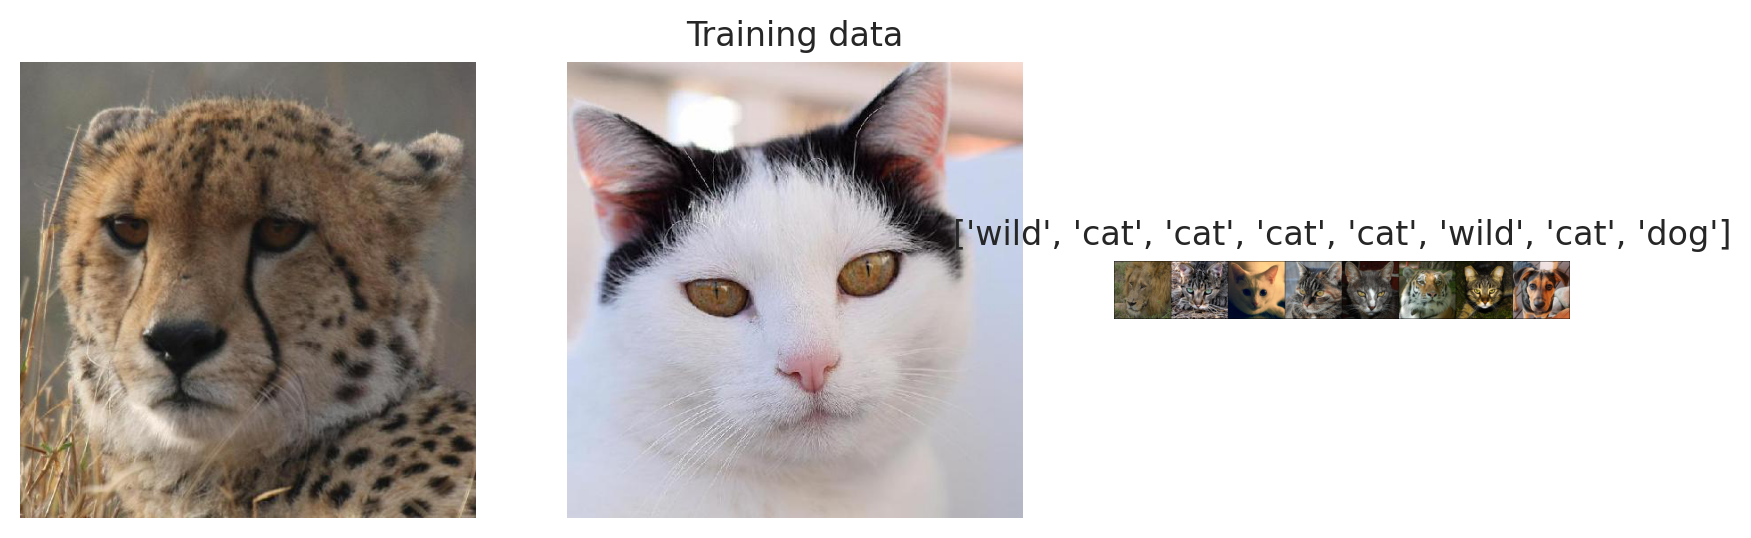

In [9]:
# plot data:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated 

img1 = data_dir + 'train/wild/flickr_wild_000769.jpg'
ax[0].axis('off')
ax[0].imshow(mpimg.imread(img1))

img2 = data_dir + 'train/cat/pixabay_cat_000250.jpg'
ax[1].axis('off')
ax[1].imshow( mpimg.imread(img2))
ax[1].set(title = "Training data")

img3 = data_dir + 'train/dog/pixabay_dog_000368.jpg'
ax[2].axis('off')
ax[2].imshow(mpimg.imread(img3));

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

The deep neural networks are known to be overconfient, so we make some attempts to mitigate this problem.

1. We start from the ordinary training of the NN.
2. Then we consider the Laplace approximation of the trained NN. The advantage of the such approach is that we did not change the training procedure.
3. Finaly, we consider the training with ELBO optimization in order to find the gaussian posterior.

To model probability output we consider linear layer + soft-max on top of the feature extractor $\phi(x)$.

$$
\begin{aligned}
& p(y_n=i|x_n, W) = \text{Softmax}(W\phi(x), i)
\end{aligned}
$$



Also we put the prior distribution over the $W$, $\pi(W) = \mathcal{N}(\text{vec}(W)|\vec{0},A^{-1})$, where matrix $A$ is diagonal.

 * We start from the ordinary training of the NN.
 * Then we consider the Laplace approximation of the trained NN. The advantage of the such approach is that we did not change the training procedure.
 * Finaly, we consider the training with ELBO optimization in order to find the gaussian posterior.

As the feature extractor ϕ(x) for this problem we will use ResNet18 torchvision.models.resnet18(pretrained=True) and train only the last FC layer.

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
        
# function that accepts an image path and returns a format to be consumed by the model 
def process_img (img_path): 
    transform_pipeline = transforms.Compose([transforms.Resize(img_size),
                                             transforms.ToTensor()])
    img = transform_pipeline(Image.open(img_path).convert("RGB")).to(device)
    return (img.unsqueeze(0))

In [12]:
torch.manual_seed(42)
np.random.seed(42)

model_conv = torchvision.models.resnet18(pretrained=True)

# Parameters of newly constructed modules have requires_grad=True by default
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names), bias = False)
for param in model_conv.fc.parameters():
    param.requires_grad = True


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

In [13]:
# training:
model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
wd = 5e-4
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9, weight_decay = wd)

# Decay LR by a factor of 0.1 every 4 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=4, gamma=0.1)

In [17]:
%cp gdrive/My\ Drive/train/out.pkl out.pkl
%ls
model_conv.load_state_dict(torch.load('out.pkl'))
# model_conv.eval()

afhq/  data/  gdrive/  out.pkl  sample_data/


<All keys matched successfully>

In [19]:
model_conv = train_model(model = model_conv, 
                         criterion = criterion, 
                         optimizer = optimizer_conv,
                         scheduler = exp_lr_scheduler, 
                         num_epochs = 1)

Epoch 0/0
----------
train Loss: 0.0970 Acc: 0.9643
val Loss: 0.0164 Acc: 0.9953

Training complete in 2m 10s
Best val Acc: 0.995333


In [ ]:
torch.save(model_conv.state_dict(), 'out.pkl' )

In [ ]:
# %ls
%cp out.pkl gdrive/My\ Drive/train/out.pkl

<a id='problem1'></a>
#### Problem 1 (10 points)
1. Fix $A$. You can think of it as a $l2$ regulariazation coefficient. Find MAP estimate of $W$, so that the accuracy of the model on the validation set is **more** than $95\%.

2. Classify some out of the distriubtion pictures. For example, photos of cars or a cartoon character or something else that enjoy. Plot them with predicted class label and probability.  

3. Make the histogram of the top-class probability over the test set.

<a id='problem2'></a>
#### Problem 2, (20 points)
1. Consider the Laplace approximation of the posterior and approximation of the posterior-predictive distribution of the trained model. As Hessian consider two options:
    - full hessian
    - only diagonal part

2. Re-do point 2. and 3. from Problem 1 and compare results between full-Laplace, diagonal part-Laplace and just MAP.

<a id='problem3'></a>
#### Problem 3, (20 points)

$$
p(Y,W|X,A) = \left[\prod\limits_{n=1}^{N}p(y_n|x_n, W)\right]\mathcal{N}(\text{vec}(W)|\vec{0},A^{-1}).
$$

And we want to optimise ELBO with variational distribution $q$:

$$
\mathcal{L}[q, A] = \int q(W)\log\frac{p(y,W|x,A)}{q(W)}dW.
$$

Let's make the following assumptions:

$$
\begin{aligned}
& q(W) = \mathcal{N}(\text{vec}(W)|m,S) \\
\end{aligned}
$$
 
The plan for the solution is the following: 
 
  1. Derive the equation for $\mathcal{L}[m, S, A]$, take all expectations that can be taken analytically. Here, again consider two options:
      - Train diagonal $S$
      - Train full covariance matrix $S$
  2. From first order condition find optimal $\alpha^{i}$ (diagonal elements of $A$).
  3. Derive the equation for $\mathcal{L}[m, S]$ by pluging-in optimal $A$. 
 
Re-do point 2. and 3. from Problem 1 above and compare results.